# Claira Project: Mortgage Contracts

## Import Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import string
import numpy as np
import gzip
np.random.seed(99)
RANDOM_STATE = 99
import datetime
pd.set_option('display.max_rows', 151)


# Import vectorizing and modeling tools in preparation for modeling steps
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction import text, stop_words
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
import time

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import spacy
import en_core_web_lg
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, auc

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


## Import Data

In [2]:
# Import the CSV file
# raw_df = pd.read_csv('../data/sasb_cash_trap_triggers.csv')

In [3]:
# Import the CSV file
raw_df = pd.read_csv('../data/sasb_cash_trap_triggers_06_02_20.csv')

In [4]:
# Review the first few rows of the data set
raw_df.head()

,Document,Sentence,Trigger,Multiclass
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",Loan Default,0
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Aggregate DSCR Fall,1
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Loan Default,1
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,Loan Default,0
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,Loan Default,0


In [5]:
# Check size of the data set
raw_df.shape

(892, 4)

In [6]:
# Check for null values
raw_df.isnull().sum()

Document      0
Sentence      0
Trigger       0
Multiclass    0
dtype: int64

## Data Cleaning

In [7]:
# Review number of Trigger types
raw_df['Trigger'].value_counts()

Unspecified                  270
Loan Default                 234
Debt Yield Fall               85
Loan default                  75
Mezzanine Default             39
Tenant Failure                35
Debt yield fall               34
Bankruptcy                    20
DSCR Fall                     18
Operator Termination          17
Sponsor Termination           14
Aggregate Debt Yield Fall     11
Mezzanine Outstanding         10
Renovations                    9
Mezzanine default              8
Aggregate debt yield fall      6
Debt Yield Falll               4
Aggregate DSCR Fall            2
Aggregate debt yield           1
Name: Trigger, dtype: int64

In [8]:
# Convert each category to Title format (to remove discrepancies based on capitalization)
raw_df['Trigger'] = raw_df['Trigger'].str.title()

In [9]:
# Review clean Trigger Types
raw_df['Trigger'].value_counts()

Loan Default                 309
Unspecified                  270
Debt Yield Fall              119
Mezzanine Default             47
Tenant Failure                35
Bankruptcy                    20
Dscr Fall                     18
Aggregate Debt Yield Fall     17
Operator Termination          17
Sponsor Termination           14
Mezzanine Outstanding         10
Renovations                    9
Debt Yield Falll               4
Aggregate Dscr Fall            2
Aggregate Debt Yield           1
Name: Trigger, dtype: int64

In [10]:
raw_df['Trigger'] = raw_df['Trigger'].str.replace('Falll', 'Fall')

In [11]:
# Rename first column (document title)
raw_df = raw_df.rename(columns = {'0': 'Document'})

In [12]:
# Drop Multiclass column for now 
raw_df = raw_df.drop('Multiclass', axis = 1)
raw_df.head()

,Document,Sentence,Trigger
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",Loan Default
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Aggregate Dscr Fall
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Loan Default
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,Loan Default
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,Loan Default


In [13]:
raw_df.shape

(892, 3)

In [14]:
# Count the number of distinct documents
num_docs = raw_df['Document'].nunique()
print(f'{num_docs} unique documents have been included in the data set')

20 unique documents have been included in the data set


In [15]:
# Review the distinct documents and the number of Trigger events identified for each
raw_df['Document'].value_counts()

20190131_02IFE7_Prospectus_SD000000002578234792.pdf    67
20190131_02IFDN_Prospectus_SD000000002578234912.pdf    66
20181231_02IEP9_Prospectus_SD000000002568455603.pdf    65
20190131_02IFCW_Prospectus_SD000000002578232050.pdf    64
20190220_02IPLU_Prospectus_SD000000002587491183.pdf    63
20190108_02IFF1_Prospectus_SD000000002570458466.pdf    60
20190208_02IM7M_Prospectus_SD000000002581684036.pdf    54
20190205_02IJ77_Prospectus_SD000000002579874729.pdf    50
20160510_02B0XU_Prospectus_SD000000002312723382.pdf    46
20180125_02FE6L_Prospectus_SD000000002394837596.pdf    44
20170525_02DG4Z_Prospectus_SD000000002352418696.pdf    42
20170525_02DFUI_Prospectus_SD000000002352389122.pdf    37
20170727_02DTVX_Prospectus_SD000000002362015714.pdf    35
20171019_02EFSE_Prospectus_SD000000002376978886.pdf    35
20170814_02E227_Prospectus_SD000000002367167139.pdf    34
20150307_028S2X_Prospectus_SD000000002389024187.pdf    29
20170616_02DNAM_Prospectus_SD000000002355931744.pdf    28
20170801_02DX5

In [16]:
# Summarize the trigger counts for the existing Document set
max_triggers = raw_df['Document'].value_counts().max()
min_triggers = raw_df['Document'].value_counts().min()
print(f'The {num_docs} Documents have trigger counts that range from {min_triggers} to {max_triggers}.')

The 20 Documents have trigger counts that range from 20 to 67.


In [17]:
# Check for duplicate rows
raw_df['is_duplicate'] = raw_df.duplicated(subset = None)
raw_df['is_duplicate'].value_counts()

False    844
True      48
Name: is_duplicate, dtype: int64

In [18]:
num_duplicated_rows = (raw_df['is_duplicate'] == True).sum()
print(f'There are {num_duplicated_rows} row duplicates in the data set.')

There are 48 row duplicates in the data set.


In [19]:
# We'll remove the extra duplicate rows
raw_df = raw_df.drop('is_duplicate', axis = 1)
raw_df = raw_df.drop_duplicates()

In [20]:
raw_df.shape

(844, 3)

In [21]:
raw_df.head()

,Document,Sentence,Trigger
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",Loan Default
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Aggregate Dscr Fall
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Loan Default
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,Loan Default
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,Loan Default


In [22]:
# Review new number of Trigger types
raw_df['Trigger'].value_counts()

Loan Default                 297
Unspecified                  261
Debt Yield Fall              110
Mezzanine Default             42
Tenant Failure                35
Aggregate Debt Yield Fall     17
Bankruptcy                    17
Dscr Fall                     16
Operator Termination          15
Sponsor Termination           14
Renovations                    9
Mezzanine Outstanding          8
Aggregate Dscr Fall            2
Aggregate Debt Yield           1
Name: Trigger, dtype: int64

In [23]:
# Review new distinct documents and the number of Trigger events identified for each
raw_df['Document'].value_counts()

20190131_02IFE7_Prospectus_SD000000002578234792.pdf    67
20190131_02IFDN_Prospectus_SD000000002578234912.pdf    66
20181231_02IEP9_Prospectus_SD000000002568455603.pdf    65
20190131_02IFCW_Prospectus_SD000000002578232050.pdf    64
20190220_02IPLU_Prospectus_SD000000002587491183.pdf    62
20190108_02IFF1_Prospectus_SD000000002570458466.pdf    54
20190208_02IM7M_Prospectus_SD000000002581684036.pdf    54
20190205_02IJ77_Prospectus_SD000000002579874729.pdf    50
20160510_02B0XU_Prospectus_SD000000002312723382.pdf    38
20171019_02EFSE_Prospectus_SD000000002376978886.pdf    35
20170525_02DG4Z_Prospectus_SD000000002352418696.pdf    34
20180125_02FE6L_Prospectus_SD000000002394837596.pdf    34
20170525_02DFUI_Prospectus_SD000000002352389122.pdf    33
20170814_02E227_Prospectus_SD000000002367167139.pdf    31
20150307_028S2X_Prospectus_SD000000002389024187.pdf    29
20170616_02DNAM_Prospectus_SD000000002355931744.pdf    28
20170727_02DTVX_Prospectus_SD000000002362015714.pdf    28
20170801_02DX5

## Reshape the Data

In this section, we'll reshape the data, such that each sentence is represented once, with separate categorization columns for each Trigger type

In [24]:
# function to reshape the dataframe such that the triggers are 0/1 columns. Remove duplicates
def reshape_trigger_representation(dataframe):
    # select trigger types
    trigger_types = list(dataframe['Trigger'].unique())
    
    # create new dataframe with unique document-sentence pairs (no duplicates)
    reshaped = dataframe.drop('Trigger', axis = 1).drop_duplicates().reset_index().drop('index', axis = 1)
    
    # select rows by trigger, reassign as 1 or 0 (for True or False)
    for tt in trigger_types:
        # select part that is trigger_type
        temp = dataframe.loc[dataframe['Trigger'] == tt].copy()

        # create a new column of true with trigger name
        temp[tt.lower().replace(' ', '_')] = np.int64(1)
        temp.drop('Trigger', axis=1, inplace=True)
        temp[tt.lower().replace(' ', '_')] = temp[tt.lower().replace(' ', '_')].astype('Int64')
        
        # left join this adjusted column to the unique data
        reshaped = reshaped.merge(temp, how='left', left_on=['Document', 'Sentence'], right_on=['Document', 'Sentence'])

    # replace nulls with False
    reshaped = reshaped.fillna(0)    
    
    return reshaped

In [25]:
# Reshape our original dataframe
df = reshape_trigger_representation(raw_df)

In [26]:
df.head()

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,aggregate_debt_yield,sponsor_termination,renovations
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
df.dtypes

Document                     object
Sentence                     object
loan_default                  Int64
aggregate_dscr_fall           Int64
dscr_fall                     Int64
unspecified                   Int64
debt_yield_fall               Int64
aggregate_debt_yield_fall     Int64
mezzanine_default             Int64
tenant_failure                Int64
mezzanine_outstanding         Int64
operator_termination          Int64
bankruptcy                    Int64
aggregate_debt_yield          Int64
sponsor_termination           Int64
renovations                   Int64
dtype: object

In [28]:
df.shape

(686, 16)

In [29]:
# We can confirm that the number of Triggers is consistent with the prior dataframe
df.sum()

Document                     20120828_01Y0R8_Prospectus_CM00000000205875087...
Sentence                     On each Business Day, the financial institutio...
loan_default                                                               297
aggregate_dscr_fall                                                          2
dscr_fall                                                                   16
unspecified                                                                261
debt_yield_fall                                                            110
aggregate_debt_yield_fall                                                   17
mezzanine_default                                                           42
tenant_failure                                                              35
mezzanine_outstanding                                                        8
operator_termination                                                        15
bankruptcy                                          

## Feature Engineering

In [30]:
# Create a column with length of Sentence
df['sentence_char_count'] = df['Sentence'].str.len()

In [31]:
df.head()

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,aggregate_debt_yield,sponsor_termination,renovations,sentence_char_count
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,446
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,836
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1772
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,302
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,235


In [32]:
# We confirm that if a sentence is Unspecified, there are no other loan events
df[df['unspecified']==1].sum()

Document                     20150307_028S2X_Prospectus_SD00000000238902418...
Sentence                     Except during a Cash Management Period, funds ...
loan_default                                                                 0
aggregate_dscr_fall                                                          0
dscr_fall                                                                    0
unspecified                                                                261
debt_yield_fall                                                              0
aggregate_debt_yield_fall                                                    0
mezzanine_default                                                            0
tenant_failure                                                               0
mezzanine_outstanding                                                        0
operator_termination                                                         0
bankruptcy                                          

## Natural Language Processing of the sentence column

In [33]:
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser'])

In [34]:
# Review a tokenized sample Sentence
[token.text for token in nlp(df['Sentence'][2])]

['During',
 'a',
 'Trigger',
 'Period',
 'or',
 'while',
 'an',
 'event',
 'of',
 'default',
 'under',
 'the',
 'Mortgage',
 'Loan',
 'is',
 'continuing',
 ',',
 'all',
 'amounts',
 'available',
 'in',
 'the',
 'Cash',
 'Management',
 'Account',
 'will',
 'be',
 'applied',
 'on',
 'each',
 'Loan',
 'Payment',
 'Date',
 'in',
 'the',
 'following',
 'order',
 'of',
 'priority',
 ':',
 '(',
 'i',
 ')',
 'to',
 'the',
 'Tax',
 'and',
 'Insurance',
 'Reserve',
 'Account',
 ',',
 '(',
 'a',
 ')',
 '1/12th',
 'of',
 'projected',
 'annual',
 'taxes',
 'and',
 '(',
 'b',
 ')',
 '1/12th',
 'of',
 'projected',
 'annual',
 'insurance',
 'premiums',
 '(',
 'unless',
 'certain',
 'blanket',
 'policies',
 'are',
 'in',
 'effect',
 ')',
 ',',
 '(',
 'ii',
 ')',
 'to',
 'the',
 'lender',
 ',',
 'the',
 'amount',
 'of',
 'all',
 'scheduled',
 'or',
 'delinquent',
 'interest',
 'and',
 'principal',
 'on',
 'the',
 'Mortgage',
 'Loan',
 'and',
 'all',
 'other',
 'amounts',
 'then',
 'due',
 'and',
 'payab

In [35]:
# Review a lemmatized sample Sentence
[token.lemma_ for token in nlp(df['Sentence'][2])]

['during',
 'a',
 'trigger',
 'period',
 'or',
 'while',
 'an',
 'event',
 'of',
 'default',
 'under',
 'the',
 'mortgage',
 'loan',
 'be',
 'continue',
 ',',
 'all',
 'amount',
 'available',
 'in',
 'the',
 'cash',
 'management',
 'account',
 'will',
 'be',
 'apply',
 'on',
 'each',
 'loan',
 'payment',
 'date',
 'in',
 'the',
 'follow',
 'order',
 'of',
 'priority',
 ':',
 '(',
 'i',
 ')',
 'to',
 'the',
 'tax',
 'and',
 'insurance',
 'reserve',
 'account',
 ',',
 '(',
 'a',
 ')',
 '1/12th',
 'of',
 'project',
 'annual',
 'tax',
 'and',
 '(',
 'b',
 ')',
 '1/12th',
 'of',
 'project',
 'annual',
 'insurance',
 'premium',
 '(',
 'unless',
 'certain',
 'blanket',
 'policy',
 'be',
 'in',
 'effect',
 ')',
 ',',
 '(',
 'ii',
 ')',
 'to',
 'the',
 'lender',
 ',',
 'the',
 'amount',
 'of',
 'all',
 'schedule',
 'or',
 'delinquent',
 'interest',
 'and',
 'principal',
 'on',
 'the',
 'mortgage',
 'loan',
 'and',
 'all',
 'other',
 'amount',
 'then',
 'due',
 'and',
 'payable',
 'under',
 'the

In [36]:
def tokenize(text):
    doc = nlp(text)
    tokens = [token.text for token in doc]
    return ' '.join(tokens)

df['SentenceTokens'] = df['Sentence'].apply(tokenize)

In [37]:
def lemmatize(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return ' '.join(lemmas)

df['SentenceLemmas'] = df['Sentence'].apply(lemmatize)

In [38]:
df.head()

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,aggregate_debt_yield,sponsor_termination,renovations,sentence_char_count,SentenceTokens,SentenceLemmas
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,446,"On each Business Day , the financial instituti...","on each business day , the financial instituti..."
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,836,The Borrower has established and is required t...,the borrower have establish and be require to ...
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1772,During a Trigger Period or while an event of d...,during a trigger period or while an event of d...
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,302,On any Business Day all amounts on deposit in ...,on any business day all amount on deposit in t...
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,235,Available funds in each Cash Management Accoun...,available fund in each cash management account...


In [39]:
# Put all sentences into a list of review tokens
all_sentence_tokens = ' '.join(df['SentenceTokens'])
all_sentence_tokens[:75]

'On each Business Day , the financial institution maintaining the blocked ac'

In [40]:
# Put all sentences into a list of review lemmas
all_sentence_lemmas = ' '.join(df['SentenceLemmas'])
all_sentence_lemmas[:75]

'on each business day , the financial institution maintain the block account'

In [41]:
sentence_token_list = [token for token in all_sentence_tokens.split(' ')]
sentence_lemma_list = [lemma for lemma in all_sentence_lemmas.split(' ')]

In [42]:
token_df = pd.Series(sentence_token_list)
lemma_df = pd.Series(sentence_lemma_list)

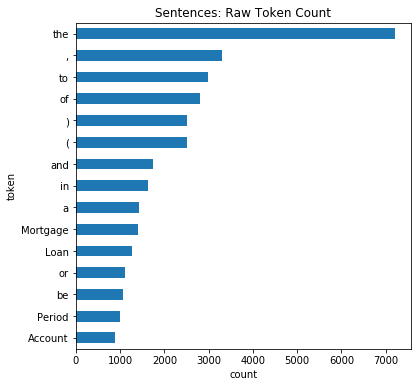

In [43]:
# Plotting the raw token count
token_series = token_df.value_counts().head(15).sort_values(ascending = True)
ax = token_series.plot.barh(figsize = (6,6))
ax.set_xlabel('count')
ax.set_ylabel('token')
ax.set_title('Sentences: Raw Token Count');

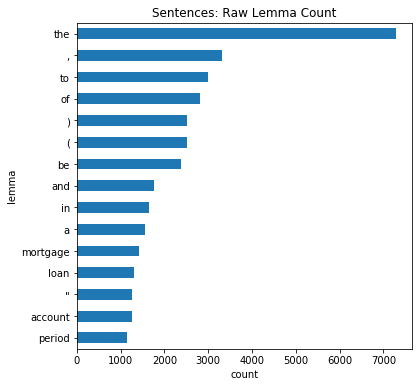

In [44]:
# Plotting the raw lemma count
lemma_series = lemma_df.value_counts().head(15).sort_values(ascending = True)
ax = lemma_series.plot.barh(figsize = (6,6))
ax.set_xlabel('count')
ax.set_ylabel('lemma')
ax.set_title('Sentences: Raw Lemma Count');

In [45]:
# Remove punctuation, maintain letters and numbers
df['SentenceLemmas_nopunc'] = df['SentenceLemmas'].str.replace("[^a-zA-Z0-9#']", " ")

In [46]:
# Put all SentenceLemmas_nopunc into a list
all_lemmas_nopunc = ' '.join(df['SentenceLemmas_nopunc'])
lemma_list_nopunc = [lemma for lemma in all_lemmas_nopunc.split(' ')]
lemma_list_nopunc = [lemma for lemma in lemma_list_nopunc if lemma not in ['']]
lemma_list_nopunc[:10]

['on',
 'each',
 'business',
 'day',
 'the',
 'financial',
 'institution',
 'maintain',
 'the',
 'block']

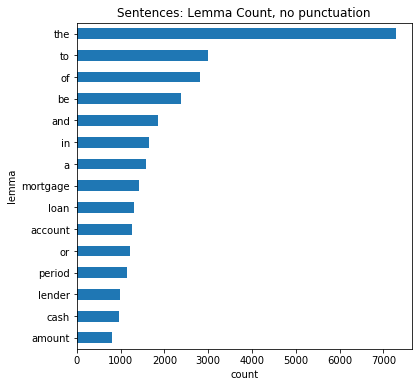

In [47]:
# Create a data series containing the list of words
lemma_df_nopunc = pd.Series(lemma_list_nopunc)
lemma_series_nopunc = lemma_df_nopunc.value_counts().head(15).sort_values(ascending = True)
ax = lemma_series_nopunc.plot.barh(figsize = (6,6))
ax.set_xlabel('count')
ax.set_ylabel('lemma')
ax.set_title('Sentences: Lemma Count, no punctuation');

In [48]:
df['SentenceLemmas_nopunc'].head()

0    on each business day   the financial instituti...
1    the borrower have establish and be require to ...
2    during a trigger period or while an event of d...
3    on any business day all amount on deposit in t...
4    available fund in each cash management account...
Name: SentenceLemmas_nopunc, dtype: object

In [49]:
df['SentenceLemmas_nopunc'] = df['SentenceLemmas_nopunc'].str.replace('\s{2,}', ' ')

In [50]:
df['SentenceLemmas_nopunc'].head()

0    on each business day the financial institution...
1    the borrower have establish and be require to ...
2    during a trigger period or while an event of d...
3    on any business day all amount on deposit in t...
4    available fund in each cash management account...
Name: SentenceLemmas_nopunc, dtype: object

## Preprocessing and Preparation for Modeling

In [51]:
short_stopwords = ['the', 'of', 'to', 'be', 'and', 'a', 'in']

In [52]:
# Look at original stopword list
stopwords = list(STOP_WORDS)
stopwords

['while',
 'four',
 'others',
 'further',
 'some',
 'six',
 'somehow',
 'what',
 'whenever',
 'besides',
 'seeming',
 'yet',
 'front',
 'done',
 'afterwards',
 'the',
 'under',
 'move',
 'sometime',
 'five',
 'otherwise',
 'wherever',
 'part',
 'latter',
 'unless',
 'empty',
 'own',
 'ten',
 'via',
 'with',
 'are',
 'much',
 'except',
 'of',
 'sixty',
 'seemed',
 'each',
 'beyond',
 'twenty',
 'he',
 'might',
 'eight',
 'put',
 'why',
 'i',
 'were',
 'for',
 'though',
 'above',
 'due',
 'neither',
 'enough',
 'thence',
 'call',
 'if',
 'is',
 'rather',
 'must',
 'them',
 'us',
 'various',
 'who',
 'would',
 'herself',
 'often',
 'next',
 'their',
 'thus',
 'on',
 'nevertheless',
 'fifty',
 'wherein',
 'from',
 'had',
 'myself',
 'its',
 'can',
 'well',
 'am',
 'you',
 'thereupon',
 'made',
 'among',
 'then',
 'most',
 'whatever',
 'almost',
 'not',
 'here',
 'even',
 'regarding',
 'her',
 'because',
 'did',
 'into',
 'our',
 'along',
 'will',
 'himself',
 'at',
 'meanwhile',
 'where',


In [53]:
# Choose to exclude anything with numbers are might be particularly relevant
to_exclude = ['thereupon', 'cannot', 'should'] 

In [54]:
# Define our selected stopword lists 
select_stopwords = [word for word in stopwords if word not in to_exclude]
select_stopwords

['while',
 'four',
 'others',
 'further',
 'some',
 'six',
 'somehow',
 'what',
 'whenever',
 'besides',
 'seeming',
 'yet',
 'front',
 'done',
 'afterwards',
 'the',
 'under',
 'move',
 'sometime',
 'five',
 'otherwise',
 'wherever',
 'part',
 'latter',
 'unless',
 'empty',
 'own',
 'ten',
 'via',
 'with',
 'are',
 'much',
 'except',
 'of',
 'sixty',
 'seemed',
 'each',
 'beyond',
 'twenty',
 'he',
 'might',
 'eight',
 'put',
 'why',
 'i',
 'were',
 'for',
 'though',
 'above',
 'due',
 'neither',
 'enough',
 'thence',
 'call',
 'if',
 'is',
 'rather',
 'must',
 'them',
 'us',
 'various',
 'who',
 'would',
 'herself',
 'often',
 'next',
 'their',
 'thus',
 'on',
 'nevertheless',
 'fifty',
 'wherein',
 'from',
 'had',
 'myself',
 'its',
 'can',
 'well',
 'am',
 'you',
 'made',
 'among',
 'then',
 'most',
 'whatever',
 'almost',
 'not',
 'here',
 'even',
 'regarding',
 'her',
 'because',
 'did',
 'into',
 'our',
 'along',
 'will',
 'himself',
 'at',
 'meanwhile',
 'where',
 'down',
 'alr

## Train/Test Split

In [55]:
df.head()

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,aggregate_debt_yield,sponsor_termination,renovations,sentence_char_count,SentenceTokens,SentenceLemmas,SentenceLemmas_nopunc
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,446,"On each Business Day , the financial instituti...","on each business day , the financial instituti...",on each business day the financial institution...
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,836,The Borrower has established and is required t...,the borrower have establish and be require to ...,the borrower have establish and be require to ...
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1772,During a Trigger Period or while an event of d...,during a trigger period or while an event of d...,during a trigger period or while an event of d...
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,302,On any Business Day all amounts on deposit in ...,on any business day all amount on deposit in t...,on any business day all amount on deposit in t...
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,235,Available funds in each Cash Management Accoun...,available fund in each cash management account...,available fund in each cash management account...


In [56]:





X = df['SentenceLemmas']
y = df['unspecified']

y = y.astype('int')

In [57]:
y.dtypes

dtype('int64')

In [58]:
# Checking shape of X and y 
print(f'X shape is {X.shape}')
print(f'y shape is {y.shape}')

X shape is (686,)
y shape is (686,)


In [59]:
y.value_counts()

0    425
1    261
Name: unspecified, dtype: int64

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(514,) (514,)
(172,) (172,)


In [61]:
X.head()

0    on each business day , the financial instituti...
1    the borrower have establish and be require to ...
2    during a trigger period or while an event of d...
3    on any business day all amount on deposit in t...
4    available fund in each cash management account...
Name: SentenceLemmas, dtype: object

In [62]:
X_train.shape[0]

514

In [63]:
y_train.shape[0]

514

## Modeling

### CountVectorizer + Logistic Regression GridSearch and modeling

In [64]:
# Define CVEC + Logistic Regression Pipeline
pipe_cvec = Pipeline([('cvec', CountVectorizer()), ('lr', LogisticRegression(solver = 'liblinear', random_state = RANDOM_STATE))])
cvec_params = {
    'cvec__ngram_range': [(1,2), (1,3), (1,4), (1,5), (1,6), ],
    'cvec__stop_words': [None, short_stopwords, select_stopwords],  
    'cvec__max_features': [30, 40, 50, 60, 70, 80, 90, 100],
    'cvec__min_df': [2,3],
    'cvec__max_df': [.99,.98],
    }

gs_cvec = GridSearchCV(pipe_cvec, param_grid = cvec_params, cv = 3, scoring = 'accuracy')

# Start the timer.
t0 = time.time()

results_cvec = gs_cvec.fit(X_train, y_train)

print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.



Seconds elapsed for fitting: 286.934


In [65]:
#log_reg = LogisticRegression()
#logreg.fit(X_train, y_train)


In [66]:
t0 = time.time()
print(f'Training score is {results_cvec.score(X_train, y_train):.3f}')
print(f'Test score is {results_cvec.score(X_test, y_test):.3f}')
print(f'Cross Validation score is {cross_val_score(results_cvec.best_estimator_, X, y, cv = 3).mean():.3f}')
print(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.

Training score is 0.977
Test score is 0.948
Cross Validation score is 0.917
Seconds elapsed for score calculation: 0.371


In [67]:
print(f'Best Score:{(results_cvec.best_score_):.3f}')
print(f'Best Parameters :{results_cvec.best_params_}')

Best Score:0.938
Best Parameters :{'cvec__max_df': 0.99, 'cvec__max_features': 90, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': ['while', 'four', 'others', 'further', 'some', 'six', 'somehow', 'what', 'whenever', 'besides', 'seeming', 'yet', 'front', 'done', 'afterwards', 'the', 'under', 'move', 'sometime', 'five', 'otherwise', 'wherever', 'part', 'latter', 'unless', 'empty', 'own', 'ten', 'via', 'with', 'are', 'much', 'except', 'of', 'sixty', 'seemed', 'each', 'beyond', 'twenty', 'he', 'might', 'eight', 'put', 'why', 'i', 'were', 'for', 'though', 'above', 'due', 'neither', 'enough', 'thence', 'call', 'if', 'is', 'rather', 'must', 'them', 'us', 'various', 'who', 'would', 'herself', 'often', 'next', 'their', 'thus', 'on', 'nevertheless', 'fifty', 'wherein', 'from', 'had', 'myself', 'its', 'can', 'well', 'am', 'you', 'made', 'among', 'then', 'most', 'whatever', 'almost', 'not', 'here', 'even', 'regarding', 'her', 'because', 'did', 'into', 'our', 'along', 'will', 'h

### 2: TFIDF + Logistic Regression GridSearch and modeling

In [68]:
# Define TFIDF + Logistic Regression Pipeline

pipe_tfidf = Pipeline([('tfidf', TfidfVectorizer()), ('lr', LogisticRegression(max_iter = 4000, random_state = RANDOM_STATE))])

tfidf_params = {
    'tfidf__ngram_range': [(1,2), (1,3), (1,4), (1,5), (1,6), (1,7), (1,8)],
    'tfidf__stop_words': [None, short_stopwords, select_stopwords],  
    'tfidf__max_features': [30, 40, 50, 60, 70, 80, 90, 100, 200],
    'tfidf__min_df': [2, 3],
    'tfidf__max_df': [.99, .98],
    }

gs_tfidf = GridSearchCV(pipe_tfidf, param_grid = tfidf_params, cv = 3, scoring = 'accuracy')

results_tfidf = gs_tfidf.fit(X_train, y_train)

print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.



Seconds elapsed for fitting: 609.585


In [69]:
t0 = time.time()
print(f'Training score is {results_tfidf.score(X_train, y_train):.3f}')
print(f'Test score is {results_tfidf.score(X_test, y_test):.3f}')
print(f'Cross Validation score is {cross_val_score(results_tfidf.best_estimator_, X, y, cv = 3).mean():.3f}')
print(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.

Training score is 0.953
Test score is 0.942
Cross Validation score is 0.882
Seconds elapsed for score calculation: 1.813


In [70]:
print(f'Best Score: {results_tfidf.best_score_}')
print(f'Best Parameters: {results_tfidf.best_params_}')

Best Score: 0.9241012738564757
Best Parameters: {'tfidf__max_df': 0.99, 'tfidf__max_features': 200, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 8), 'tfidf__stop_words': ['while', 'four', 'others', 'further', 'some', 'six', 'somehow', 'what', 'whenever', 'besides', 'seeming', 'yet', 'front', 'done', 'afterwards', 'the', 'under', 'move', 'sometime', 'five', 'otherwise', 'wherever', 'part', 'latter', 'unless', 'empty', 'own', 'ten', 'via', 'with', 'are', 'much', 'except', 'of', 'sixty', 'seemed', 'each', 'beyond', 'twenty', 'he', 'might', 'eight', 'put', 'why', 'i', 'were', 'for', 'though', 'above', 'due', 'neither', 'enough', 'thence', 'call', 'if', 'is', 'rather', 'must', 'them', 'us', 'various', 'who', 'would', 'herself', 'often', 'next', 'their', 'thus', 'on', 'nevertheless', 'fifty', 'wherein', 'from', 'had', 'myself', 'its', 'can', 'well', 'am', 'you', 'made', 'among', 'then', 'most', 'whatever', 'almost', 'not', 'here', 'even', 'regarding', 'her', 'because', 'did', 'into', 'our',

### 3: CountVectorizer + Multinomial Naive Bayes GridSearch & modeling

In [71]:
# Define CountVectorizer + Multinomial Naive Bayes Grisearch pipeline

pipe_mnb = Pipeline([('cvec', CountVectorizer()), ('mnb', MultinomialNB())])
mnb_params = {
    'cvec__ngram_range': [(1,2), (1,3), (1,4), (1,5), (1,6), (1,7), (1,8)],
    'cvec__stop_words': [None, short_stopwords, select_stopwords],
    'cvec__max_features': [30, 40, 50, 60, 70, 80, 90, 100, 200],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.98, .99],
    }

gs_mnb = GridSearchCV(pipe_mnb, param_grid = mnb_params, cv = 3, scoring = 'accuracy')

# Start the timer.
t0 = time.time()

results_mnb = gs_mnb.fit(X_train, y_train)

print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.

Seconds elapsed for fitting: 582.716


In [72]:
t0 = time.time()
print(f'Training score is {results_mnb.score(X_train, y_train):.3f}')
print(f'Test score is {results_mnb.score(X_test, y_test):.3f}')
print(f'Cross Validation score is {cross_val_score(results_mnb.best_estimator_, X, y, cv = 3).mean():.3f}')
print(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.

Training score is 0.918
Test score is 0.907
Cross Validation score is 0.888
Seconds elapsed for score calculation: 0.518


In [73]:
print(f'Best Score: {results_mnb.best_score_}')
print(f'Best Parameters: {results_mnb.best_params_}')

Best Score: 0.9124167006663946
Best Parameters: {'cvec__max_df': 0.98, 'cvec__max_features': 200, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': ['while', 'four', 'others', 'further', 'some', 'six', 'somehow', 'what', 'whenever', 'besides', 'seeming', 'yet', 'front', 'done', 'afterwards', 'the', 'under', 'move', 'sometime', 'five', 'otherwise', 'wherever', 'part', 'latter', 'unless', 'empty', 'own', 'ten', 'via', 'with', 'are', 'much', 'except', 'of', 'sixty', 'seemed', 'each', 'beyond', 'twenty', 'he', 'might', 'eight', 'put', 'why', 'i', 'were', 'for', 'though', 'above', 'due', 'neither', 'enough', 'thence', 'call', 'if', 'is', 'rather', 'must', 'them', 'us', 'various', 'who', 'would', 'herself', 'often', 'next', 'their', 'thus', 'on', 'nevertheless', 'fifty', 'wherein', 'from', 'had', 'myself', 'its', 'can', 'well', 'am', 'you', 'made', 'among', 'then', 'most', 'whatever', 'almost', 'not', 'here', 'even', 'regarding', 'her', 'because', 'did', 'into', 'our', 'alo

### 4: TFIDF + Gaussian Naive Bayes GridSearch & modeling

In [74]:
# Define TFIDF + Gaussian Naive Bayes Gridsearch pipeline

from sklearn.base import TransformerMixin
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()


pipe_gnb = Pipeline([('tfidf', TfidfVectorizer()), ('to_dense', DenseTransformer()),('gnb', GaussianNB())])

gnb_params = {
    'tfidf__ngram_range': [(1,2), (1,3), (1,4), (1,5), (1,6), (1,7)],
    'tfidf__stop_words': [None, short_stopwords, select_stopwords],
    'tfidf__max_features': [50, 60, 70, 80, 90, 100, 200, 400, 600],
    'tfidf__min_df': [2, 3],
    'tfidf__max_df': [.99, .98],
    }

gs_gnb = GridSearchCV(pipe_gnb, param_grid = gnb_params, cv = 3, scoring = 'accuracy')

# Start the timer.
t0 = time.time()

results_gnb = gs_gnb.fit(X_train, y_train)

print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.

Seconds elapsed for fitting: 442.845


In [75]:
t0 = time.time()
print(f'Training score is {results_gnb.score(X_train, y_train):.3f}')
print(f'Test score is {results_gnb.score(X_test, y_test):.3f}')
print(f'Cross Validation score is {cross_val_score(results_gnb.best_estimator_, X, y, cv = 3).mean():.3f}')
print(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.

Training score is 0.967
Test score is 0.948
Cross Validation score is 0.895
Seconds elapsed for score calculation: 1.141


In [76]:
print(f'Best Score: {results_gnb.best_score_}')
print(f'Best Parameters: {results_gnb.best_params_}')

Best Score: 0.94937440500476
Best Parameters: {'tfidf__max_df': 0.99, 'tfidf__max_features': 400, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 4), 'tfidf__stop_words': None}


## Model Selection
- In this section we compare the Train and Test scores across the various models

In [77]:
# Check Training Scores across all models
print(f'Baseline Score:                                {y_test.value_counts(normalize=True)[0]:.3f}')
print(f'CountVectorizer + LogisticRegression Accuracy: {results_cvec.score(X_train, y_train):.3f}')
print(f'TfidfVectorizer + LogisticRegression Accuracy: {results_tfidf.score(X_train, y_train):.3f}')
print(f'CountVectorizer + Multinomial Naive Bayes:     {results_mnb.score(X_train, y_train):.3f}')
print(f'TfidfVectorizer + Gaussian Naive Bayes:        {results_gnb.score(X_train, y_train):.3f}')

Baseline Score:                                0.610
CountVectorizer + LogisticRegression Accuracy: 0.977
TfidfVectorizer + LogisticRegression Accuracy: 0.953
CountVectorizer + Multinomial Naive Bayes:     0.918
TfidfVectorizer + Gaussian Naive Bayes:        0.967


In [78]:
# Check Testing Scores across all models
print(f'Baseline Score:                                {y_test.value_counts(normalize=True)[0]:.3f}')
print(f'CountVectorizer + LogisticRegression Accuracy: {results_cvec.score(X_test, y_test):.3f}')
print(f'TfidfVectorizer + LogisticRegression Accuracy: {results_tfidf.score(X_test, y_test):.3f}')
print(f'CountVectorizer + Multinomial Naive Bayes:     {results_mnb.score(X_test, y_test):.3f}')
print(f'TfidfVectorizer + Gaussian Naive Bayes:        {results_gnb.score(X_test, y_test):.3f}')

Baseline Score:                                0.610
CountVectorizer + LogisticRegression Accuracy: 0.948
TfidfVectorizer + LogisticRegression Accuracy: 0.942
CountVectorizer + Multinomial Naive Bayes:     0.907
TfidfVectorizer + Gaussian Naive Bayes:        0.948


## Model Evaluation

In [79]:
# Isolate the individual words and their coefficients
# Feature names (i.e., words in the Sentences):
names = results_cvec.best_estimator_.steps[0][1].get_feature_names()

# classifier (betas):
classifier = results_cvec.best_estimator_.named_steps['lr']

# https://stackoverflow.com/questions/43856280/return-coefficients-from-pipeline-object-in-sklearn

In [80]:
# Extract coefficients from the classifier defined above
coef_cvec = np.array(classifier.coef_).tolist()[0]
coef_cvec[:10] #Look at 10 coefficients

[0.7612639219006301,
 0.19194945045523304,
 -0.5484203572402151,
 0.8682155327934356,
 -0.5454628515335656,
 0.03898358736525979,
 0.04239379423817222,
 0.24695057165412207,
 0.31217506673797824,
 -0.34125549193562804]

In [81]:
# Create zipped list of the word names with their corresponding beta coefficients
cvec_top_words = list(zip(names, coef_cvec))

In [82]:
# Create final dataframe of words with their corresponding coefficients
df_cvec_coefs = pd.DataFrame(cvec_top_words).rename(columns = {0: 'word', 1: 'coef'}).sort_values(by = 'coef', ascending = False)

In [83]:
# Display top differentiating words and phrases in predicting Trigger Event
df_cvec_coefs.head(20)

,word,coef
88,trigger period,1.158504
15,cure,1.032664
3,applicable,0.868216
11,cash sweep,0.795812
79,sufficient,0.790850
0,accordance,0.761264
59,occurrence,0.740066
30,excess cash,0.655650
64,payment date,0.632804
42,leasing,0.575170


In [84]:
# Top differentiating words and phrases predicting a non-Trigger Event
df_cvec_coefs.tail(20).sort_values('coef', ascending = True)

,word,coef
28,event default,-2.203824
21,default,-1.949841
48,low,-1.212421
27,event,-1.139229
47,loan event,-0.963687
84,tenant,-0.955003
18,debt,-0.934411
74,reserve account,-0.818502
85,tenant trigger,-0.722564
89,yield,-0.710405


### Calculating predictions and Confusion Matrix

In [85]:
# Here, we isolate our best model & make predictions based on our test data
best_model = results_gnb.best_estimator_
preds = best_model.predict(X_test)

In [86]:
# Checking our predictions
preds[:10]

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 0])

In [87]:
## Create a confusion matrix
from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(y_test, preds)
print('This is a confusion matrix for our test data vs predictions:')
print(cm_test)

This is a confusion matrix for our test data vs predictions:
[[100   5]
 [  4  63]]


In [88]:
# Converting our confusion matrix into a dataframe
cm_test = pd.DataFrame(cm_test, columns=['Predicted Negative','Predicted Positive'], 
                       index=['Actual Negative','Actual Positive'])

In [89]:
cm_test

,Predicted Negative,Predicted Positive
Actual Negative,100,5
Actual Positive,4,63


In [90]:
# Setting up probabilities for the ROC curve
pred_proba = results_gnb.predict_proba(X_test)
preds = results_gnb.predict(X_test)

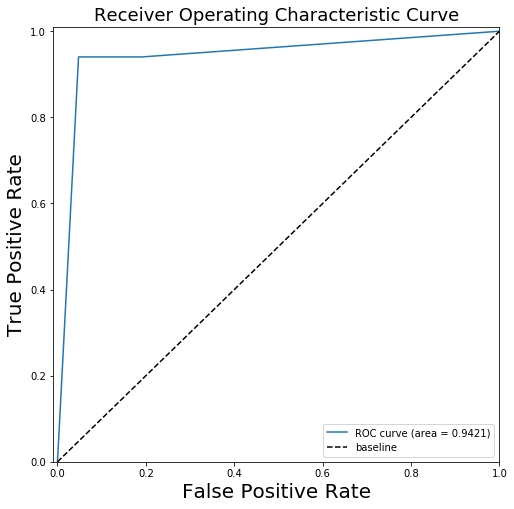

In [91]:
fpr, tpr, _= roc_curve(y_test, pred_proba[:,1])
roc_auc = auc(fpr, tpr)
# Plot of a ROC curve for a specific class
plt.figure(figsize = (8,8))
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='baseline')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate', fontsize =20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.title('Receiver Operating Characteristic Curve', fontsize=18)
plt.legend(loc="lower right");

In [92]:
# To allow us to better read the Sentences
pd.set_option('display.max_colwidth', None)

In [93]:
result_cols = ['prediction', 'actual', 'Sentence']
results = pd.DataFrame({'prediction': list(preds), 'actual': list(y_test), 'Sentence': list(X_test)})
results.head()

,prediction,actual,Sentence
0,0,0,""" mezzanine loan default "" mean an "" event of default "" under the mezzanine loan document ."
1,0,0,"provide that no mortgage loan event of default be continue , the lender will release to the borrowers’ operate account all amount then contain in the excess cash flow reserve account on the first payment date follow termination of a cash sweep period ."
2,0,0,"mortgage lender will disburse to the borrower the leasing reserve funds upon satisfaction by the borrower of each of the following condition : ( i ) the borrower will submit a request for payment to mortgage lender at least 10 business days prior to the date on which the borrower request such payment be make and specifie the approved leasing costs to be pay ; ( ii ) on the date such request be receive by mortgage lender and on the date such payment be to be make , no mortgage loan event of default will exist and remain uncured ; and ( iii ) mortgage lender will have receive a certificate from the borrower state either that such tenant improvement payment be require to be pay to the tenant under -PRON- lease or , otherwise , ( a ) state that the item to be fund by the request disbursement be approve leasing costs , ( b ) state to the borrower ’s knowledge , that all tenant improvement at the property to be fund by the request disbursement have be complete ( or complete to the extent of the request disbursement ) in good and workmanlike manner and in accordance with all applicable federal , state and local law , rule and regulation , and ( c ) state that each person that supply material or labor in connection with the tenant improvement to be fund by the request disbursement have be pay in full for work complete through such date or will be pay in full upon such disbursement ( or if progress payment be be make , that such person have be or will be pay all amount owe to -PRON- base on the work such person have complete ) ; ( iv ) at mortgage lender ’s option , if the amount of any individual disbursement of leasing reserve funds exceed $ 250,000 , a title search for the property indicate that the property be free from all lien , claim and other encumbrance not previously approve by mortgage lender ; and ( v ) mortgage lender will have receive such other evidence as mortgage lender will reasonably request that the approved leasing costs to be fund by the request disbursement have be complete ( to the extent applicable ) , be due and payable and be pay for or will be pay upon such disbursement to the borrower ."
3,0,0,"a "" trigger period "" will commence upon the occurrence of ( i ) an event of default , ( ii ) a low debt yield trigger period or ( iii ) the commencement of an event of default under the mezzanine loan ; and will end if , ( a ) with respect to a trigger period continue pursuant to clause ( i ) , the event of default commence the trigger period have be cure and such cure have be accept by the lender ( and no other event of default be then continue ) , ( b ) with respect to a trigger period continue pursuant to clause ( ii ) , the low debt yield trigger period have end or ( c ) with respect to a trigger period continue pursuant to clause ( iii ) , receipt by the lender of a mezzanine loan default revocation notice ."
4,0,0,""" low cash flow period "" mean a period : ( a ) commence upon the debt yield ( test quarterly ) fall below ( a ) six percent ( 6.0 % ) during the initial term of the whole loan or the first , second or third extension period or ( b ) six and one - half percent ( 6.50 % ) during the fourth or fifth extension period , in each case for any two ( 2 ) consecutive fiscal quarter ; and ( b ) expire upon the date that the debt yield ( test quarterly ) be equal to or great than ( a ) six percent ( 6.00 % ) during the initial term of the whole loan or the first , second or third extension period or ( b ) six and one - half percent ( 6.50 % ) during the fourth or fifth extension period , in each case for any two ( 2

In [94]:
misclassified = results[results['prediction'] != results['actual']]


In [95]:
misclassified.head(10)

prediction  actual  \
19            1       0   
38            0       1   
39            0       1   
51            1       0   
53            0       1   
132           0       1   
153           1       0   
168           1       0   
171           1       0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [96]:
df.loc[42]

Document                                                                                                            20150307_028S2X_Prospectus_SD000000002389024187.pdf
Sentence                        During the continuance of a Cash Management Period, Borrower shall deposit a monthly amount of $24,369.30 into the replacement reserve.
loan_default                                                                                                                                                          0
aggregate_dscr_fall                                                                                                                                                   0
dscr_fall                                                                                                                                                             0
unspecified                                                                                                                                                     